In [1]:
import numpy as np
import re
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import nltk

In [2]:
nltk.data.path.append("/kaggle/input/nltk-data/nltk-data")

In [3]:
train_essays_df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
display(train_essays_df)

train_essays_df['generated'].value_counts()

train_essays_df[train_essays_df['generated']==1]

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [4]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation
print(stop_words)
print(punctuations)

{'now', 'enough', 'made', 'become', 'were', 'because', 'alone', 'does', 'whole', 'into', 'one', 'further', 'yourselves', 'nevertheless', 'my', 'otherwise', 'third', 'see', 'perhaps', 'themselves', 'per', 'that', "'d", 'anything', 'nor', 'each', 'throughout', 'their', 'regarding', 'there', 'no', '’m', 'both', 'do', 'eleven', 'after', 'hence', 'himself', 'if', 'it', 'forty', 'yourself', 'ourselves', 'whereafter', '‘ll', 'those', 'ours', 'then', 'always', 'beside', 'due', 'hereby', 'herein', '’s', 'me', 'myself', 'get', 'already', 'least', 'thru', 'but', 'will', 'them', 'eight', 'he', 'besides', 'fifty', 'to', 'they', 'when', 'n‘t', 'becoming', 'elsewhere', 'with', 'anyway', 'rather', 'either', 'keep', 'nine', 'onto', 'over', 'part', 'becomes', 'against', 'done', 'whether', 'him', 'two', 'until', 'yours', 'never', 'how', 'towards', 'take', "n't", 'are', 'afterwards', 'namely', 'noone', 'make', 'whereby', 'been', 'only', 'very', 'should', "'m", '‘d', 'behind', '’ve', 'twenty', 'first', 'st

In [5]:
def clean_text(text):
    doc = nlp(text.lower().strip())
    tokens = [word.lemma_ for word in doc if word.text not in stop_words and word.text not in punctuations]
    return " ".join(tokens)

In [6]:
train_essays_df['cleaned_text'] = train_essays_df['text'].apply(clean_text)

In [7]:
X = train_essays_df['cleaned_text']
y = train_essays_df['generated']
tfidf = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

In [8]:
X_tfidf_shuffled, y_shuffled = shuffle(X_tfidf, y, random_state=42)

In [9]:
model = SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(model, parameters, cv=5)

# Fit and Tune Model
clf.fit(X_tfidf_shuffled, y_shuffled)
print("Best Parameters:", clf.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'C': 1, 'kernel': 'linear'}


In [10]:
skf = StratifiedKFold(n_splits=5)
accuracies = []
for train_index, test_index in skf.split(X_tfidf_shuffled, y_shuffled):
    X_train, X_test = X_tfidf_shuffled[train_index], X_tfidf_shuffled[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

    model.set_params(**clf.best_params_)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

print("Average accuracy:", np.mean(accuracies))

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Average accuracy: 0.9978260869565216


In [13]:
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_tfidf = tfidf.transform(test_df['cleaned_text'])

In [16]:
submit = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
submit['generated'] = model.predict_proba(test_tfidf)[:,1]

submit.to_csv('submission.csv', index=False)

In [17]:
submit.head()

,id,generated
0,0000aaaa,0.009435
1,1111bbbb,0.009435
2,2222cccc,0.009435


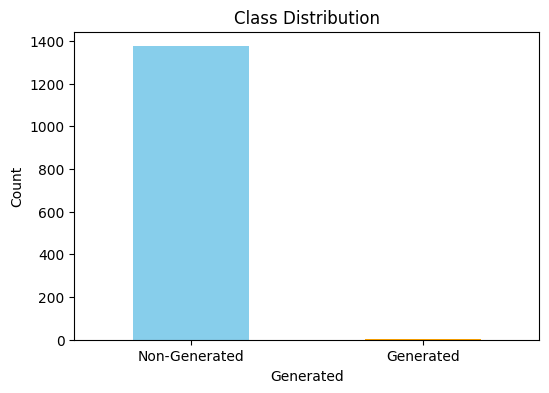

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
train_essays_df['generated'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Generated', 'Generated'], rotation=0)
plt.show()